I am using a polytropic equation of state, which is defined as

$$ P(\varepsilon) = K\varepsilon^\gamma  $$

Since I'm using scaled units, the goal is to have an equation written in the form

$$ P'(\varepsilon') = K'\varepsilon'^{\gamma} $$

Here are the steps to transform the first equation into the second one. First define 

$$ \varepsilon = \varepsilon_0 \varepsilon' $$
$$ P = \varepsilon_0 P' $$

Then

$$ P = K\varepsilon^\gamma  $$
$$ \varepsilon_0 P' = K(\varepsilon_0 \varepsilon')^\gamma  $$
$$ \varepsilon_0 P' = K\varepsilon_0^\gamma\varepsilon'^\gamma  $$
$$ P' = K(\varepsilon_0^{\gamma - 1})\varepsilon'^\gamma  $$

Which can be simplified using $K' = K(\varepsilon_0^{\gamma - 1})$

$$ P' = K'\varepsilon'^\gamma $$

To remove the dimensional $\varepsilon_0$ from the equation, it's necessary to find a value for which $K' = 1$.

$$ K' = 1 $$
$$ K(\varepsilon_0^{\gamma - 1}) = 1 $$
$$ \varepsilon_0^{\gamma - 1} = \frac{1}{K} $$
$$ \varepsilon_0 = \frac{1}{K}^\frac{1}{\gamma - 1} = K^{\frac{-1}{\gamma-1}}$$


These are the TOV equations.

$$
\frac{dm_r}{dr} = 4\pi r^2 \varepsilon(r)
$$

$$
\frac{dP}{dr}=
    -G\frac{m_r(r)\varepsilon(r)}{r^2}
    \left(1+\frac{P(r)}{\varepsilon(r)}\right)
    \left(1+\frac{4\pi r^3 P(r)}{m_r(r)}\right)
    \left(1-\frac{2 Gm_r(r)}{r}\right)^{-1}
$$

$r$ = radius (km).

$m_r(r)$ = the radius enclosed within a radius $r$ in ($M_\odot$).

$P(r)$ = the pressure at radius $r$ (_MeV/fm<sup>3</sup>_).

$\varepsilon(r)$ = energy density at radius $r$ (_MeV/fm<sup>3</sup>_).

$G$ = gravitational constant.



I'm going to start by using the dimensionless TOV equations.

$$
\frac{dP'}{dr'}=
    \left(-\frac{m_r' e'}{r'^2} \right)
    \left(1 + \frac{P'}{\varepsilon} \right)
    \left(1 + \frac{4\pi r'^3 P'}{m_r'} \right)
    \left(1 - \frac{2m_r'}{r'} \right)^{-1}
$$

Where a quantity being primed denotes that it is a unitless value being scaled by a constant with the units of energy density, $\varepsilon_0$. For example, $P = \varepsilon_0 P'$ (also meaning that $P' = \frac{P}{\varepsilon_0}$). To convert back to the original units, I can use the equations

$$ m_r = \frac{m_r'}{(G^3 \varepsilon_0)^\frac{1}{2}} $$

$$ r = \frac{r'}{(G\varepsilon_0)^\frac{1}{2}} $$

In [ ]:
# Convenience conversion functions

import numpy as np
from scipy.constants import G

def geometrized_energy_density_to_si(epsilon):
    '''
    Convert from `MeV/fm^3` to `J/m^3`.
    
    The conversion from `MeV` to `J` is the factor 1.602176634 * 10^-13.
    The conversion from `fm^3` to `m^3` is the factor 10^-45.
    Together, these result in a conversion factor of 1.602176634 * 10^32.
    '''
    conversion_factor = 1.602176634e32
    return epsilon * conversion_factor
    
# Scaling constant - based on a rough estimate from pressure vs energy density graph, and converting from MeV/fm^3 to J/m^3.
EPSILON_0 = 1e34 # J/m^3 to match G when rescaling
    
@np.vectorize
def convert_pressure_to_nu(P_prime):
    return P_prime * EPSILON_0

@np.vectorize
def convert_mass_to_nu(m_prime):
    '''
    Returns the mass in natural units (solar masses) where `m_prime` is the scaled value.
    '''
    M_SUN = 1.98847e30 # kg
    mass_kg = m_prime / ((G**3 * EPSILON_0)**(1/2))
    return mass_kg / M_SUN

@np.vectorize
def convert_radius_to_nu(r_prime):
    '''
    Returns the radius in natural units (km) where `r_prime` is the scaled value.
    '''
    radius_meters = r_prime / ((G * EPSILON_0)**(1/2)) 
    return radius_meters / 1000


In [ ]:
import numpy as np
from scipy.constants import pi, G
from scipy.integrate import solve_ivp

def eos_epsilon(P_prime):
    '''
    Calculates the energy density as a function of `P'`.
    '''
    gamma = 2.0
    K = 1.0
    K_prime = K * (EPSILON_0 ** (gamma - 1))
    return (P_prime/K_prime)**(1/gamma)

def dimensionless_tov_rhs(r, state):
    '''
    Returns [dP/dr, dm/dr] using a TOV equation scaled by an energy density constant. Treat every 
    value with a unit as being dimensionless.
    '''
    # Pressure, mass, and density at the current radius
    P_r, m_r = state
    if P_r <= 0: # Bad things happen when P_r is negative.
        return [0, 0]
    else:
        e_r = eos_epsilon(P_r)
        # Mass 
        dm_dr = 4*pi * r**2 * e_r
        # Pressure (split into factors)
        f1 = -(m_r * e_r) / (r ** 2)
        f2 = 1 + (P_r / e_r)
        f3 = 1 + ((4*pi * (r**3) * P_r) / m_r)
        f4 = (1 - (2 * m_r / r)) ** -1
        dp_dr = f1 * f2 * f3 * f4
        return [dp_dr, dm_dr]

def pressure_boundary_event(r, state):
    '''
    Event for solve_ivp() that returns 0 when the pressure is 0,
    indicating that the edge fo the star has been reached.
    '''
    p, _ = state
    return p

# Cancel solve_ivp() when radius reaches boundary.
pressure_boundary_event.terminal = True
# Only trigger event when going from psoitive to negative
pressure_boundary_event.direction = -1

def small_r_expansion(r_0, P_c):
    return ((4*pi)/3) * r_0**3 * eos_epsilon(P_c)

# Starting radius
R_START = 1e-6
# Maximum possible radius. solve_ivp() shoud terminate before reaching this value.
R_END = 100
# Central pressure.
P_C = 1e2
# Central enclosed mass.
M_0 = small_r_expansion(R_START, P_C) # Solar Masses

def solve():
    '''
    Use solve_ivp() to find solutions using the scaled TOV equations. Then, the results are rescaled
    and added to a `MassRadiusSolutions` object.
    '''
    solutions = solve_ivp(
        dimensionless_tov_rhs,
        t_span=(R_START, R_END),
        y0=(P_C, M_0),
        events=pressure_boundary_event
    )
    return solutions

Radius Solutions: [1.22404431e-21 8.50208895e-18 3.51521938e-17 6.45358471e-17
 9.19584726e-17 1.18508619e-16 1.48428016e-16 1.82650659e-16
 2.21871537e-16 2.66718179e-16 3.17728142e-16 3.74708133e-16
 4.34313847e-16 4.81765330e-16 5.17799322e-16 5.47934673e-16
 5.72387946e-16 5.85946971e-16 5.99505997e-16 6.01501685e-16]
Mass Solutions: [3.86332265e-49 1.28145261e-37 7.87535349e-36 3.82442593e-35
 8.76827773e-35 1.51504888e-34 2.37900305e-34 3.49982580e-34
 4.88405219e-34 6.50031633e-34 8.26355412e-34 1.00111178e-33
 1.14806251e-33 1.23436446e-33 1.28086571e-33 1.30682586e-33
 1.31905944e-33 1.32242494e-33 1.32327839e-33 1.32337808e-33]


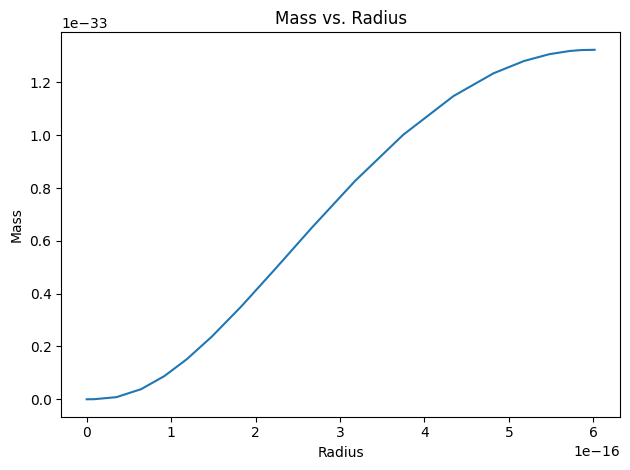

In [33]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

solutions = solve()
r_solutions = convert_radius_to_nu(solutions.t)
m_solutions = convert_mass_to_nu(solutions.y[1])

subplots: tuple[Figure, Axes] = plt.subplots()
fig, ax = subplots

ax.set_title("Mass vs. Radius")
ax.set_ylabel("Mass")
ax.set_xlabel("Radius")
# ax.plot(solutions.t, solutions.y[1])
ax.plot(r_solutions, m_solutions)
print(f'Radius Solutions: {r_solutions}')
print(f"Mass Solutions: {m_solutions}")

fig.tight_layout()
plt.show()